In [1]:
# load necessary modules

import numpy as np
import pandas as pd
from functools import partial
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
import matplotlib as mpl
from scipy import optimize
from time import time
from matplotlib.patches import ConnectionPatch
import itertools, os
%matplotlib inline

In [5]:
np.random.seed(123)
gau = np.random.normal(0,1,10000)

In [63]:
# UFL 
def draw_stat_ufl(mu0, sigma0, q0, mu1, sigma1, q1, mu2, sigma2, q2, resolution = 100):
    def p_inverse(y):
        y = max(y, 1e-10)
        return  - np.log(max(1/y-1, 1e-10))
    
    def acc(lbd, sigma = 0.2, mu = (10, 9.8), q = 0.5):
        def p(x):
            return 1/(1+np.exp(-x))
        def a(x, mu, sigma, s):
            y = (x + mu) * sigma
            if s == 0:
                return int(p(y) > (1/2-lbd/2/(1-q)))*(1 - 2*p(y))
            else:
                return int(p(y) > (1/2+lbd/2/q))*(1 - 2*p(y))
        av0 = np.vectorize(partial(a, sigma = sigma, mu =  mu[0], s = 0))
        av1 = np.vectorize(partial(a, sigma = sigma, mu =  mu[1], s = 1))
        return 1-(1-q)*np.mean(av0(gau))- q*np.mean(av1(gau))-(1-q)*np.mean(p((gau+mu[0])*sigma))-q*np.mean(p((gau+mu[1])*sigma)) 
    acc0 = partial(acc, sigma = sigma0, mu = mu0, q = q0)
    acc1 = partial(acc, sigma = sigma1, mu = mu1, q = q1)
    acc2 = partial(acc, sigma = sigma2, mu = mu2, q = q2)
    acc0_v = np.vectorize(acc0)
    acc1_v = np.vectorize(acc1)
    acc2_v = np.vectorize(acc2)

    def g(lbd, sigma, q, mu = (-1, 0)):
        return norm.cdf(p_inverse(1/2+lbd/2/q), loc = mu[1], scale = sigma) - norm.cdf(p_inverse(1/2-lbd/2/(1-q)), loc = mu[0], scale = sigma)
    g0 = partial(g, sigma = sigma0, q = q0, mu = mu0)
    g1 = partial(g, sigma = sigma1, q = q1, mu = mu1)
    g2 = partial(g, sigma = sigma2, q = q2, mu = mu2)
    
    step = 1/resolution
    if g0(0) > 0:
        ginverse0 = optimize.root_scalar(g0, bracket = [-max(q0, 1-q0),0], method = 'brentq').root
        lbd0_list = np.concatenate([np.arange(ginverse0,0,step), np.array([0])])
    else:
        ginverse0 = optimize.root_scalar(g0, bracket = [0, max(q0, 1-q0)], method = 'brentq').root
        lbd0_list = np.concatenate([np.arange(0,ginverse0,step), np.array([ginverse0])])
        
    if g1(0) > 0:
        ginverse1 = optimize.root_scalar(g1, bracket = [-max(q1, 1-q1),0], method = 'brentq').root
        lbd1_list = np.concatenate([np.arange(ginverse1,0,step), np.array([0])])
    else:
        ginverse1 = optimize.root_scalar(g1, bracket = [0,max(q1, 1-q1)], method = 'brentq').root
        lbd1_list = np.concatenate([np.arange(0,ginverse1,step), np.array([ginverse1])])
        
    if g2(0) > 0:
        ginverse2 = optimize.root_scalar(g2, bracket = [-max(q2, 1-q2),0], method = 'brentq').root
        lbd2_list = np.concatenate([np.arange(ginverse2,0,step), np.array([0])])
    else:
        ginverse2 = optimize.root_scalar(g2, bracket = [0,max(q2, 1-q2)], method = 'brentq').root
        lbd2_list = np.concatenate([np.arange(0,ginverse2,step), np.array([ginverse2])])
        
    lbd_list = np.unique(np.concatenate([lbd0_list, lbd1_list, lbd2_list]))
    acc0_df = pd.DataFrame({'lambda': lbd_list, 'acc': acc0_v(lbd_list)}).set_index('lambda')
    acc1_df = pd.DataFrame({'lambda': lbd_list, 'acc': acc1_v(lbd_list)}).set_index('lambda')
    acc2_df = pd.DataFrame({'lambda': lbd_list, 'acc': acc2_v(lbd_list)}).set_index('lambda')
    
    def DPDisp(lbd0, lbd1, lbd2):
        t1 = (1-q0)/(3-q0-q1-q2) * (3-norm.cdf(p_inverse(1/2-lbd0/2/(1-q0)), loc = mu0[0], scale = sigma0)-norm.cdf(p_inverse(1/2-lbd1/2/(1-q1)), loc = mu0[0], scale = sigma0)-norm.cdf(p_inverse(1/2-lbd2/2/(1-q2)), loc = mu0[0], scale = sigma0))/3
        t2 = (1-q1)/(3-q0-q1-q2) * (3-norm.cdf(p_inverse(1/2-lbd0/2/(1-q0)), loc = mu1[0], scale = sigma1)-norm.cdf(p_inverse(1/2-lbd1/2/(1-q1)), loc = mu1[0], scale = sigma1)-norm.cdf(p_inverse(1/2-lbd2/2/(1-q2)), loc = mu1[0], scale = sigma1))/3
        t3 = (1-q2)/(3-q0-q1-q2) * (3-norm.cdf(p_inverse(1/2-lbd0/2/(1-q0)), loc = mu2[0], scale = sigma2)-norm.cdf(p_inverse(1/2-lbd1/2/(1-q1)), loc = mu2[0], scale = sigma2)-norm.cdf(p_inverse(1/2-lbd2/2/(1-q2)), loc = mu2[0], scale = sigma2))/3
        t4 = q0/(q0+q1+q2) * (3-norm.cdf(p_inverse(1/2+lbd0/2/q0), loc = mu0[1], scale = sigma0)-norm.cdf(p_inverse(1/2+lbd1/2/q1), loc = mu0[1], scale = sigma0)-norm.cdf(p_inverse(1/2+lbd2/2/q2), loc = mu0[1], scale = sigma0))/3
        t5 = q1/(q0+q1+q2) * (3-norm.cdf(p_inverse(1/2+lbd0/2/q0), loc = mu1[1], scale = sigma1)-norm.cdf(p_inverse(1/2+lbd1/2/q1), loc = mu1[1], scale = sigma1)-norm.cdf(p_inverse(1/2+lbd2/2/q2), loc = mu1[1], scale = sigma1))/3
        t6 = q2/(q0+q1+q2) * (3-norm.cdf(p_inverse(1/2+lbd0/2/q0), loc = mu2[1], scale = sigma2)-norm.cdf(p_inverse(1/2+lbd1/2/q1), loc = mu2[1], scale = sigma2)-norm.cdf(p_inverse(1/2+lbd2/2/q2), loc = mu2[1], scale = sigma2))/3
        return abs(t1 + t2 + t3 - t4 - t5 - t6)
    
    def Acc(lbd0, lbd1, lbd2):
        return (acc0_df.loc[lbd0]['acc'] + acc0_df.loc[lbd1]['acc'] + acc0_df.loc[lbd2]['acc'] + 
                acc1_df.loc[lbd0]['acc'] + acc1_df.loc[lbd1]['acc'] + acc1_df.loc[lbd2]['acc'] + 
                acc2_df.loc[lbd0]['acc'] + acc2_df.loc[lbd1]['acc'] + acc2_df.loc[lbd2]['acc'])/9
    
    lbd0, lbd1, lbd2 = np.meshgrid(lbd0_list, lbd1_list, lbd2_list)
    lbd0, lbd1, lbd2 = lbd0.reshape(-1), lbd1.reshape(-1), lbd2.reshape(-1)
    
    acc_l, dp_l = [], []
    for l0, l1, l2 in zip(lbd0, lbd1, lbd2):
        acc_l.append(Acc(l0, l1, l2))
        dp_l.append(DPDisp(l0, l1, l2))
        
    df = pd.DataFrame({'acc': acc_l, 'c': dp_l}).sort_values(by = 'c').reset_index(drop = True)
    acc_max = 0
    for i in range(len(df)):
        acc_max = max(acc_max, df['acc'].iloc[i])
        df.loc[i, 'acc'] = acc_max
    
    df = pd.concat([df, pd.DataFrame({'acc': [df.iloc[-1]['acc']], 'c': [1]})]).reset_index(drop = True)
    return df
    
    

In [64]:
mu0, sigma0, mu1, sigma1, mu2, sigma2 = (3,5), 1, (1,-1), 1, (1,2), 1

In [65]:
ufl = draw_stat_ufl(mu0 = mu0, sigma0 = sigma0, q0 = 0.5, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.5, resolution = 200)
ufl1 = draw_stat_ufl(mu0 = mu0, sigma0 = sigma0, q0 = 0.4, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.6, resolution = 200)
ufl2 = draw_stat_ufl(mu0 = mu0, sigma0 = sigma0, q0 = 0.3, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.7, resolution = 200)
ufl3 = draw_stat_ufl(mu0 = mu0, sigma0 = sigma0, q0 = 0.2, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.8, resolution = 200)

In [66]:
ufl.to_csv(os.path.join('data', 'figure2_ufl_3clients.csv'), index=False)
ufl1.to_csv(os.path.join('data', 'figure2_ufl1_3clients.csv'), index=False)
ufl2.to_csv(os.path.join('data', 'figure2_ufl2_3clients.csv'), index=False)
ufl3.to_csv(os.path.join('data', 'figure2_ufl3_3clients.csv'), index=False)

In [23]:
# CFL
def draw_stat_cfl(mu0, sigma0, q0, mu1, sigma1, q1, mu2, sigma2, q2, resolution = 100):
    # note that the mixture distribution doesn't follow normal distribution 
    q = (q0 + q1)/2
    def p_inverse(y):
        y = max(y, 1e-10)
        return  - np.log(max(1/y-1, 1e-10))
    def g(lbd):
        t1 = (1-q0)/(3-q0-q1-q2) * (1-norm.cdf(p_inverse(1/2-lbd/2/(1-q)), loc = mu0[0], scale = sigma0))
        t2 = (1-q1)/(3-q0-q1-q2) * (1-norm.cdf(p_inverse(1/2-lbd/2/(1-q)), loc = mu1[0], scale = sigma1))
        t3 = (1-q2)/(3-q0-q1-q2) * (1-norm.cdf(p_inverse(1/2-lbd/2/(1-q)), loc = mu2[0], scale = sigma2))
        t4 = q0/(q0+q1+q2) * (1-norm.cdf(p_inverse(1/2+lbd/2/q), loc = mu0[1], scale = sigma0))
        t5 = q1/(q0+q1+q2) * (1-norm.cdf(p_inverse(1/2+lbd/2/q), loc = mu1[1], scale = sigma1))
        t6 = q2/(q0+q1+q2) * (1-norm.cdf(p_inverse(1/2+lbd/2/q), loc = mu2[1], scale = sigma2))
        return t1 + t2 + t3 - t4 - t5 - t6
    
    step = 1/resolution
    if g(0) > 0:
        ginverse = optimize.root_scalar(g, bracket = [-max(q, 1-q),0], method = 'brentq').root
        lbd_list = np.concatenate([np.arange(ginverse,0,step), np.array([0])])
    else:
        ginverse = optimize.root_scalar(g, bracket = [0, max(q, 1-q)], method = 'brentq').root
        lbd_list = np.arange(0,ginverse+step,step)
        
    def acc(lbd, sigma = 0.2, mu = (10, 9.8), q_ = 0.5):
        def p(x):
            return 1/(1+np.exp(-x))
        def a(x, mu, sigma, s):
            y = (x + mu) * sigma
            if s == 0:
                return int(p(y) > (1/2-lbd/2/(1-q)))*(1 - 2*p(y))
            else:
                return int(p(y) > (1/2+lbd/2/q))*(1 - 2*p(y))
        av0 = np.vectorize(partial(a, sigma = sigma, mu =  mu[0], s = 0))
        av1 = np.vectorize(partial(a, sigma = sigma, mu =  mu[1], s = 1))
        return 1-(1-q_)*np.mean(av0(gau))- q_*np.mean(av1(gau))-(1-q_)*np.mean(p((gau+mu[0])*sigma))-q_*np.mean(p((gau+mu[1])*sigma)) 
    acc0 = partial(acc, sigma = sigma0, mu = mu0, q_ = q0)
    acc1 = partial(acc, sigma = sigma1, mu = mu1, q_ = q1)   
    acc2 = partial(acc, sigma = sigma2, mu = mu2, q_ = q2)   
    
    def Acc(lbd):
        return acc0(lbd)/3 + acc1(lbd)/3 + acc2(lbd)/3

    acc_l, dp_l = [], []
    for lbd in lbd_list:
        acc_l.append(Acc(lbd))
        dp_l.append(abs(g(lbd)))
    df = pd.DataFrame({'acc': acc_l, 'c': dp_l}).sort_values(by = 'c').reset_index(drop = True)
    df = pd.concat([df, pd.DataFrame({'acc': [df['acc'].iloc[-1]], 'c': [1]})]).reset_index(drop = True)
    return df
    

In [24]:
cfl = draw_stat_cfl(mu0 = mu0, sigma0 = sigma0, q0 = 0.5, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.5, resolution = 200)
cfl1 = draw_stat_cfl(mu0 = mu0, sigma0 = sigma0, q0 = 0.4, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.6, resolution = 200)
cfl2 = draw_stat_cfl(mu0 = mu0, sigma0 = sigma0, q0 = 0.3, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.7, resolution = 200)
cfl3 = draw_stat_cfl(mu0 = mu0, sigma0 = sigma0, q0 = 0.2, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.8, resolution = 200)

In [39]:
cfl.to_csv(os.path.join('data', 'figure2_cfl_3clients.csv'), index=False)
cfl1.to_csv(os.path.join('data', 'figure2_cfl1_3clients.csv'), index=False)
cfl2.to_csv(os.path.join('data', 'figure2_cfl2_3clients.csv'), index=False)
cfl3.to_csv(os.path.join('data', 'figure2_cfl3_3clients.csv'), index=False)

In [59]:
# FFL 
def draw_stat_ffl(mu0, sigma0, q0, mu1, sigma1, q1, mu2, sigma2, q2, resolution = 100):
    def p(x):
        return 1/(1+np.exp(-x))
    
#     def f(x,a,lbd):
#         lbd0, lbd1 = lbd
#         if norm.pdf(x, loc = mu0[a], scale = sigma0) > norm.pdf(x, loc = mu1[a], scale = sigma1):
#             if a == 0:
#                 return int(2*p(x) - 1 + lbd0/(1-q0) > 0)
#             else:
#                 return int(2*p(x) - 1 - lbd0/q0 > 0)
#         else:
#             if a == 0:
#                 return int(2*p(x) - 1 + lbd1/(1-q1) > 0)
#             else:
#                 return int(2*p(x) - 1 - lbd1/q1 > 0)
            
    def f_a0(x,lbd):
        lbd0, lbd1, lbd2 = lbd
        signal = (2*p(x) - 1 + lbd0/(1-q0)) * norm.pdf(x, loc = mu0[0], scale = sigma0) +  (2*p(x) - 1 + lbd1/(1-q1)) * norm.pdf(x, loc = mu1[0], scale = sigma1) + (2*p(x) - 1 + lbd2/(1-q2)) * norm.pdf(x, loc = mu2[0], scale = sigma2)
        return signal > 0
    def f_a1(x,lbd):
        lbd0, lbd1, lbd2 = lbd
        signal = (2*p(x) - 1 - lbd0/q0) * norm.pdf(x, loc = mu0[0], scale = sigma0) + (2*p(x) - 1 - lbd1/q1) * norm.pdf(x, loc = mu1[0], scale = sigma1) + (2*p(x) - 1 - lbd2/q2) * norm.pdf(x, loc = mu2[0], scale = sigma2)
        return signal > 0
    
    def local_dp(lbd, i):
        lbd0, lbd1, lbd2 = lbd
        # fv_a0 = np.vectorize(partial(f, a = 0, lbd = lbd))
        fv_a0 = partial(f_a0, lbd=lbd)
        # fv_a1 = np.vectorize(partial(f, a = 1, lbd = lbd))
        fv_a1 = partial(f_a1, lbd=lbd)
        
        if i == 0:
            return abs(np.mean(fv_a0((gau + mu0[0])*sigma0)) - np.mean(fv_a1((gau+mu0[1])*sigma0)))
        elif i == 1:
            return abs(np.mean(fv_a0((gau + mu1[0])*sigma1)) - np.mean(fv_a1((gau+mu1[1])*sigma1)))
        else:
            return abs(np.mean(fv_a0((gau + mu2[0])*sigma2)) - np.mean(fv_a1((gau+mu2[1])*sigma2)))
        
    def global_dp(lbd):
        lbd0, lbd1, lbd2 = lbd
#         fv_a0 = np.vectorize(partial(f, a = 0, lbd = lbd))
#         fv_a1 = np.vectorize(partial(f, a = 1, lbd = lbd))
        fv_a0 = partial(f_a0, lbd=lbd)
        fv_a1 = partial(f_a1, lbd=lbd)
        t1 = (1-q0)/(3-q0-q1-q2) * np.mean(fv_a0((gau + mu0[0])*sigma0))
        t2 = (1-q1)/(3-q0-q1-q2) * np.mean(fv_a0((gau + mu1[0])*sigma1))
        t3 = (1-q1)/(3-q0-q1-q2) * np.mean(fv_a0((gau + mu2[0])*sigma2))
        t4 = q0/(q0+q1+q2) * np.mean(fv_a1((gau+mu0[1])*sigma0))
        t5 = q1/(q0+q1+q2) * np.mean(fv_a1((gau+mu1[1])*sigma1))
        t6 = q1/(q0+q1+q2) * np.mean(fv_a1((gau+mu2[1])*sigma2))
        return abs(t1 + t2 + t3 - t4 - t5 - t6)
    
    def acc(lbd, sigma = 0.2, mu = (10, 9.8), q_ = 0.5):
#         def a(x, mu, sigma, s):
#             y = (x + mu) * sigma
#             return f(y,s,lbd) * (1-2*p(y))
        def a0(x,mu,sigma):
            y = (x + mu) * sigma
            return f_a0(y,lbd) * (1-2*p(y))
        def a1(x,mu,sigma):
            y = (x + mu) * sigma
            return f_a1(y,lbd) * (1-2*p(y))
        
        av0 = partial(a0, sigma = sigma, mu =  mu[0])
        av1 = partial(a1, sigma = sigma, mu =  mu[1])
        return 1-(1-q_)*np.mean(av0(gau))- q_*np.mean(av1(gau))-(1-q_)*np.mean(p((gau+mu[0])*sigma))-q_*np.mean(p((gau+mu[1])*sigma))
    
    acc0 = partial(acc, sigma = sigma0, mu = mu0, q_ = q0)
    acc1 = partial(acc, sigma = sigma1, mu = mu1, q_ = q1)   
    acc2 = partial(acc, sigma = sigma2, mu = mu2, q_ = q2)   
    
    def Acc(lbd):
        return acc0(lbd)/3 + acc1(lbd)/3 + acc2(lbd)/3
    
    step = 1/resolution
    lbd0_list = np.arange(-max(q0,1-q0),max(q0,1-q0)+step,step)
    lbd1_list = np.arange(-max(q1,1-q1),max(q1,1-q1)+step,step)
    lbd2_list = np.arange(-max(q2,1-q2),max(q2,1-q2)+step,step)
    
#     start = time()
#     acc_l, dp0_l, dp1_l, dp_l = [], [], [], []
#     for lbd0, lbd1 in itertools.product(lbd0_list, lbd1_list):
#         # print(1)
#         # t0 = time()
#         acc_l.append(Acc((lbd0, lbd1)))
#         # t1 = time()
#         # print(t1-t0)
#         dp0_l.append(local_dp((lbd0, lbd1), 0))
#         # t2 = time()
#         # print(t2-t1)
#         dp1_l.append(local_dp((lbd0, lbd1), 1))
#         # t3 = time()
#         # print(t3-t2)
#         dp_l.append(global_dp((lbd0, lbd1)))
#     df = pd.DataFrame({'acc': acc_l, 'c0': dp0_l, 'c1': dp1_l, 'c': dp_l})

#     df = pd.DataFrame(np.array(list(map(lambda lbd: (Acc(lbd), local_dp(lbd, 0), local_dp(lbd, 1), global_dp(lbd)), itertools.product(lbd0_list, lbd1_list)))),
#                      columns = ['acc', 'c0', 'c1', 'c'])
    
    lbd0, lbd1, lbd2 = np.meshgrid(lbd0_list, lbd1_list, lbd2_list)
    lbd0_list, lbd1_list, lbd2_list = lbd0.reshape(-1), lbd1.reshape(-1), lbd2.reshape(-1)
    acc_l, dp0_l, dp1_l, dp2_l, dp_l = [], [], [], [], []
    for lbd0, lbd1, lbd2 in zip(lbd0_list, lbd1_list, lbd2_list):
        acc_l.append(Acc((lbd0, lbd1, lbd2)))

        dp0_l.append(local_dp((lbd0, lbd1, lbd2), 0))
        dp1_l.append(local_dp((lbd0, lbd1, lbd2), 1))
        dp2_l.append(local_dp((lbd0, lbd1, lbd2), 2))

        dp_l.append(global_dp((lbd0, lbd1, lbd2)))
    df = pd.DataFrame({'acc': acc_l, 'c0': dp0_l, 'c1': dp1_l, 'c2': dp2_l, 'c': dp_l})
    # print(time()-start)
    
    i = 0
    while i < len(df):
        c0_ = df.iloc[i]['c0']
        c1_ = df.iloc[i]['c1']
        c2_ = df.iloc[i]['c2']
        acc_ = df.iloc[i]['acc']
        rm = np.where((df['c0'] > c0_) & (df['c1'] > c1_) & (df['c2'] > c2_) & (df['acc'] < acc_))[0]
        i = i - sum(rm < i) + 1
        df = df.drop(labels = rm, axis = 0).reset_index(drop = True)
    df = df.sort_values(by = 'c').reset_index(drop = True)
    
    max_acc = 0
    for i in range(len(df)):
        if df.iloc[i]['acc'] > max_acc:
            max_acc = df.iloc[i]['acc']
        else:
            df.iloc[i]['acc'] = max_acc
    df = pd.concat([df, pd.DataFrame({'acc': [df.iloc[-1]['acc']], 'c': [1]})]).reset_index(drop = True)
    return df
                

In [70]:
ffl = draw_stat_ffl(mu0 = mu0, sigma0 = sigma0, q0 = 0.5, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.5, resolution = 33)
ffl1 = draw_stat_ffl(mu0 = mu0, sigma0 = sigma0, q0 = 0.4, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.6, resolution = 33)
ffl2 = draw_stat_ffl(mu0 = mu0, sigma0 = sigma0, q0 = 0.3, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.7, resolution = 33)
ffl3 = draw_stat_ffl(mu0 = mu0, sigma0 = sigma0, q0 = 0.2, mu1 = mu1, sigma1 = sigma1, q1 = 0.5, mu2 = mu2, sigma2 = sigma2, q2 = 0.8, resolution = 33)

In [73]:
ffl.to_csv(os.path.join('data', 'figure2_ffl_3clients.csv'), index=False)
ffl1.to_csv(os.path.join('data', 'figure2_ffl1_3clients.csv'), index=False)
ffl2.to_csv(os.path.join('data', 'figure2_ffl2_3clients.csv'), index=False)
ffl3.to_csv(os.path.join('data', 'figure2_ffl3_3clients.csv'), index=False)

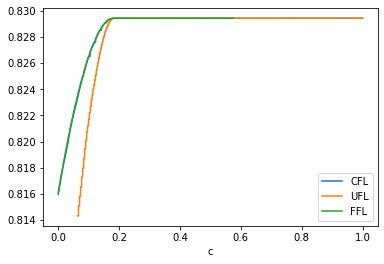

In [71]:
ax = cfl.plot(x = 'c', y = 'acc', label = 'CFL')
ufl.plot(x = 'c', y = 'acc', ax = ax, label = 'UFL')
ffl.plot(x = 'c', y = 'acc', ax = ax, label = 'FFL')
None

# Load the data

In [2]:
ufl = pd.read_csv(os.path.join('data', 'figure2_ufl_3clients.csv'))
cfl = pd.read_csv(os.path.join('data', 'figure2_cfl_3clients.csv'))
ffl = pd.read_csv(os.path.join('data', 'figure2_ffl_3clients.csv'))

ufl1 = pd.read_csv(os.path.join('data', 'figure2_ufl1_3clients.csv'))
cfl1 = pd.read_csv(os.path.join('data', 'figure2_cfl1_3clients.csv'))
ffl1 = pd.read_csv(os.path.join('data', 'figure2_ffl1_3clients.csv'))

ufl2 = pd.read_csv(os.path.join('data', 'figure2_ufl2_3clients.csv'))
cfl2 = pd.read_csv(os.path.join('data', 'figure2_cfl2_3clients.csv'))
ffl2 = pd.read_csv(os.path.join('data', 'figure2_ffl2_3clients.csv'))

ufl3 = pd.read_csv(os.path.join('data', 'figure2_ufl3_3clients.csv'))
cfl3 = pd.read_csv(os.path.join('data', 'figure2_cfl3_3clients.csv'))
ffl3 = pd.read_csv(os.path.join('data', 'figure2_ffl3_3clients.csv'))

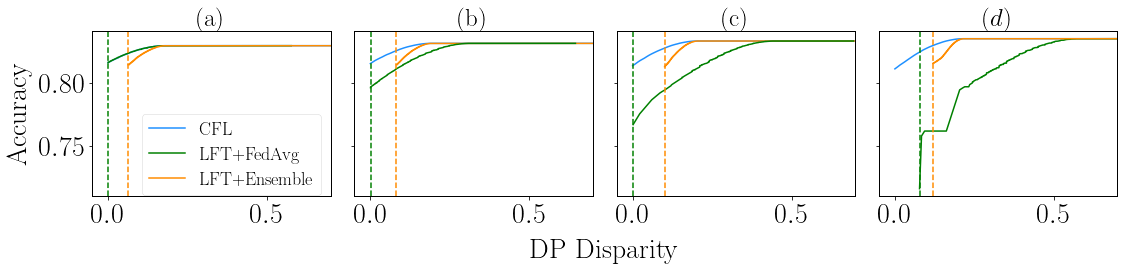

In [3]:
width = 16
height = width/3.7

plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, (ax, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True) #plot two subgraphs in one figure, 1 by 2 size, sharing y-axis
fig.subplots_adjust(left=.08, bottom=.35, right=0.97, top=0.88, wspace=0.1) #margin of the figure
fig.set_size_inches(width, height) #exact size of the figure

plt.xlim(-0.05,0.7)

#color setting#
cflc = 'dodgerblue'
uflc = 'darkorange'
fflc = 'green'
###############

cfl.plot(x = 'c', y = 'acc', ax = ax, label = 'CFL', color = cflc)
ffl.plot(x = 'c', y = 'acc', ax = ax, label = 'LFT+FedAvg', color = fflc)
ufl.plot(x = 'c', y = 'acc', ax = ax, label = 'LFT+Ensemble', color = uflc)
ax.axvline(x=ufl['c'].iloc[0], color=uflc, linestyle='--')
ax.axvline(x=ffl['c'].iloc[0], color=fflc, linestyle='--')
ax.set_xlabel('')
ax.legend(fontsize = 18, bbox_to_anchor=(0.17, 0.55))
ax.set_title('(a)', fontsize = 25)

cfl1.plot(x = 'c', y = 'acc', ax = ax1, label = 'CFL', color = cflc)
ufl1.plot(x = 'c', y = 'acc', ax = ax1, label = 'LFT+Ensemble', color = uflc)
ffl1.plot(x = 'c', y = 'acc', ax = ax1, label = 'LFT+FedAvg', color = fflc)
ax1.axvline(x=ufl1['c'].iloc[0], color=uflc, linestyle='--')
ax1.axvline(x=ffl1['c'].iloc[0], color=fflc, linestyle='--')
ax1.set_xlabel('')
ax1.get_legend().remove()
ax1.set_title('(b)', fontsize = 25)

cfl2.plot(x = 'c', y = 'acc', ax = ax2, label = 'CFL', color = cflc)
ufl2.plot(x = 'c', y = 'acc', ax = ax2, label = 'LFT+Ensemble', color = uflc)
ffl2.plot(x = 'c', y = 'acc', ax = ax2, label = 'LFT+FedAvg', color = fflc)
ax2.axvline(x=ufl2['c'].iloc[0], color=uflc, linestyle='--')
ax2.axvline(x=ffl2['c'].iloc[0], color=fflc, linestyle='--')
ax2.set_xlabel('')
ax2.legend(fontsize = 16.5, bbox_to_anchor=(0.37, 0.48))
ax2.set_title('(c)', fontsize = 25)
ax2.get_legend().remove()

# ax4 = plt.axes([.9, .27, .06, .2])
# cfl3.plot(x = 'c', y = 'acc', ax = ax4, label = 'CFL', color = cflc)
# ufl3.plot(x = 'c', y = 'acc', ax = ax4, label = 'UFL', color = uflc)
# ffl3.plot(x = 'c', y = 'acc', ax = ax4, label = 'FFL', color = fflc)
# ax4.set_xlim(0.5, 0.6)
# ax4.set_ylim(0.825, 0.839)
# ax4.get_legend().remove()
# ax4.get_xaxis().set_visible(False)
# ax4.get_yaxis().set_visible(False)
# con1 = ConnectionPatch(xyA=(0.57, 0.83), coordsA=ax3.transData, 
#                         xyB=(0.53, 0.84), coordsB=ax4.transData, color = 'black', linewidth=2,arrowstyle='->')
# # Add left side to the figure
# fig.add_artist(con1)

cfl3.plot(x = 'c', y = 'acc', ax = ax3, label = 'CFL', color = cflc)
ffl3.plot(x = 'c', y = 'acc', ax = ax3, label = 'FFL', color = fflc)
ufl3.plot(x = 'c', y = 'acc', ax = ax3, label = 'UFL', color = uflc)
ax3.axvline(x=ufl3['c'].iloc[0], color=uflc, linestyle='--')
ax3.axvline(x=ffl3['c'].iloc[0], color=fflc, linestyle='--')
ax3.set_title(r'$(d)$', fontsize = 25)
ax3.set_xlabel('')
ax3.get_legend().remove()

#a nice trick to add common x_label and y_label
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("DP Disparity", labelpad = 10)
plt.ylabel("Accuracy", labelpad = 20)
# lines, labels = ax1.get_legend_handles_labels()
# fig.legend(lines, labels, loc = 'upper center')
# plt.text(-0.05,-0.34,'DH:', fontsize = 30)

plt.savefig('figure2_3clients.pdf')
None